In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests
from scipy.integrate import simps

# Read data

In [4]:
# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)

# read bacterial relative abundance
df_16S_absab = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# read qPCR
df_qpcr = pd.read_csv('../../../our_data/qPCR.csv', index_col=0).rename({'Value':'qPCR'},axis=1)
                      
# read scfa
df_scfa = pd.read_csv('../../../our_data/SCFA.csv', index_col=0)

# join tables
df = pd.merge(df_meta, df_16S_absab, left_index=True, right_index=True)
df = pd.merge(df, df_qpcr, left_index=True, right_index=True)
df = pd.merge(df, df_scfa, left_index=True, right_index=True)

# select for rs
df = df[df.Diet=='Resistant starch']

# add eco-groups
primary_degraders = ['Muribaculaceae','Faecalibaculum','Desulfovibrionaceae']
df_rs_responders = pd.read_csv('../../figure4_individualized_response/resistant_starch/individualized_response_bacteria_species_absolute_abundance.csv', index_col=0)
df_rs_responders = df_rs_responders[(df_rs_responders.P_rsp_corrected<0.05)&(df_rs_responders.meanAbsab_ratio>1)]
generic_responders = list(set(df_rs_responders.Variable) - set(primary_degraders))
non_responders = list(set(df_16S_absab.columns) - set(primary_degraders) - set(generic_responders))

df['PrimaryDegraders'] = df[primary_degraders].sum(axis=1)
df['GenericResponders'] = df[generic_responders].sum(axis=1)
df['NonResponders'] = df[non_responders].sum(axis=1)

df.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,A2,ASF356,Acetatifactor,Acetatifactor-muris,Acidovorax,...,Acetate,Propionate,Butyrate,Iso-butyrate,Iso-valerate,Valerate,Total,PrimaryDegraders,GenericResponders,NonResponders
SampleID,,,,,,,,,,,,,,,,,,,,,
sample136,BR1,Beijing,0,Resistant starch,C,181936.0571,153346.10530,179336.970600,0.0,0.0,...,22.405910,4.444321,3.492211,0.363462,0.168020,0.509784,31.383708,9.721363e+07,2.948924e+07,7.810255e+07
sample137,BR2,Beijing,0,Resistant starch,D,0.0000,73905.43893,33503.798980,0.0,0.0,...,12.848765,2.011738,0.846365,0.061972,0.015822,0.050137,15.834799,3.208087e+07,8.563177e+06,4.099880e+07
sample138,BR3,Beijing,0,Resistant starch,B,0.0000,29302.31897,0.000000,0.0,0.0,...,22.307053,3.581340,2.125602,0.206319,0.097680,0.098607,28.416602,4.139597e+07,8.784835e+06,3.823835e+07
sample139,BR4,Beijing,0,Resistant starch,E,0.0000,113937.68040,2729.046237,0.0,0.0,...,21.643676,3.958831,2.736517,0.369261,0.171036,0.170434,29.049754,4.837644e+07,8.772519e+06,2.999904e+07
sample140,BR5,Beijing,0,Resistant starch,A,0.0000,134327.71380,35482.792330,0.0,0.0,...,7.491250,1.564890,0.597219,0.074267,0.041139,-0.014784,9.768765,6.689520e+07,1.598500e+07,6.790393e+07


In [32]:
df_rs_responders

,Variable,pF_ind,P_ind,pF_rsp,P_rsp,P_ind_corrected,log10(P_ind_corrected),P_rsp_corrected,log10(P_rsp_corrected),meanAbsab_rs,log10(meanAbsab_rs),meanAbsab_cellulose,log10(meanAbsab_cellulose),meanAbsab_ratio,log10(meanAbsab_ratio)
19,Alistipes-sp.-cv1,3.393727,0.007800,4.903490,0.005300,0.011797,-1.928228,0.043546,-1.361052,1.267282e+04,4.102873,9.802999e+03,3.991359,1.292750,0.111514
28,Anaerotruncus,5.309727,0.012000,6.096638,0.003700,0.017538,-1.756009,0.038786,-1.411323,1.013401e+06,6.005781,8.537387e+05,5.931325,1.187015,0.074456
39,Bacteroidales,7.884097,0.000001,6.428773,0.000500,0.000005,-5.309518,0.008000,-2.096910,3.242240e+04,4.510845,4.968788e+02,2.696250,65.252141,1.814595
41,Bacteroides-acidifaciens,19.636203,0.000001,9.648060,0.000200,0.000005,-5.309518,0.004343,-2.362224,9.769171e+06,6.989858,4.334428e+06,6.636932,2.253855,0.352926
53,Bifidobacterium,6.138540,0.000001,4.235583,0.000400,0.000005,-5.309518,0.007600,-2.119186,8.388918e+04,4.923706,1.041597e+04,4.017700,8.053899,0.906006
84,Clostridia-UCG-014,5.702257,0.000004,5.124455,0.000020,0.000018,-4.734610,0.000468,-3.330040,1.628652e+06,6.211828,5.174863e+05,5.713899,3.147236,0.497929
103,Coriobacteriaceae-UCG-002,25.983060,0.000001,5.292674,0.005300,0.000005,-5.309518,0.043546,-1.361052,1.033926e+04,4.014489,1.460450e+03,3.164487,7.079503,0.850003
108,Defluviitaleaceae-UCG-011,1.459158,0.235500,8.325208,0.001100,0.279656,-0.553375,0.015200,-1.818156,7.877054e+03,3.896364,3.279116e+03,3.515757,2.402189,0.380607
139,Faecalibaculum,6.717793,0.000300,88.854074,0.000001,0.000620,-3.207322,0.000034,-4.471369,1.171252e+07,7.068650,3.524703e+06,6.547123,3.322980,0.521528
147,Frisingicoccus,3.708224,0.001600,3.188990,0.004200,0.002779,-2.556044,0.039900,-1.399027,6.045231e+03,3.781413,1.533568e+02,2.185703,39.419388,1.595710


In [29]:
generic_responders

['Parabacteroides-goldsteinii',
 'Bacteroidales',
 'Frisingicoccus',
 '[Eubacterium]-oxidoreducens-group',
 'Prevotellaceae-UCG-001',
 'GCA-900066575',
 'Ruminococcaceae',
 'Tannerellaceae',
 'Anaerotruncus',
 'Defluviitaleaceae-UCG-011',
 'Lachnospiraceae-AC2044-group',
 'Gastranaerophilales',
 'Bifidobacterium',
 'Parvibacter',
 'UCG-010',
 '[Clostridium]-leptum',
 'Lachnospiraceae',
 'Clostridia-UCG-014',
 'Lachnospiraceae-NK4A136-group',
 'Coriobacteriaceae-UCG-002',
 'Alistipes-sp.-cv1',
 'Lactobacillus',
 'Muribaculum',
 'Bacteroides-acidifaciens',
 'Roseburia']

# Correlation between total bacterial load and SCFA

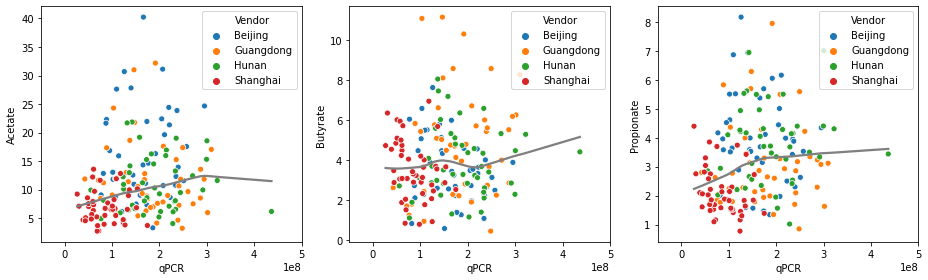

In [7]:
fig, ax=plt.subplots(nrows=1, ncols=3, figsize=(13,4))

lines = []
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    _ = sns.regplot(x='qPCR', y=scfa, data=df, ax=ax[k], scatter=False, color='gray', ci=68, lowess=True)
    _ = sns.scatterplot(x='qPCR', y=scfa, data=df, ax=ax[k], hue='Vendor')
    coef, P = spearmanr(df['qPCR'], df[scfa])
    lines.append([scfa, coef, P])
    if k==0:
        _ = ax[k].set_xlim([-5e7, 5e8])
    elif k==1:
        _ = ax[k].set_xlim([-5e7, 5e8])
    elif k==2:
        _ = ax[k].set_xlim([-5e7, 5e8])

df_res = pd.DataFrame(lines, columns=['SCFA','Coef','P'])
df_res['P_adj'] = multipletests(df_res.P, method='fdr_bh')[1]

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_load_and_scfa.svg", format="svg")

In [8]:
df_res

,SCFA,Coef,P,P_adj
0,Acetate,0.249578,0.000808,0.001508
1,Butyrate,0.045403,0.548458,0.548458
2,Propionate,0.245174,0.001005,0.001508


# Correlation of baseline microbiota with total bacterial load

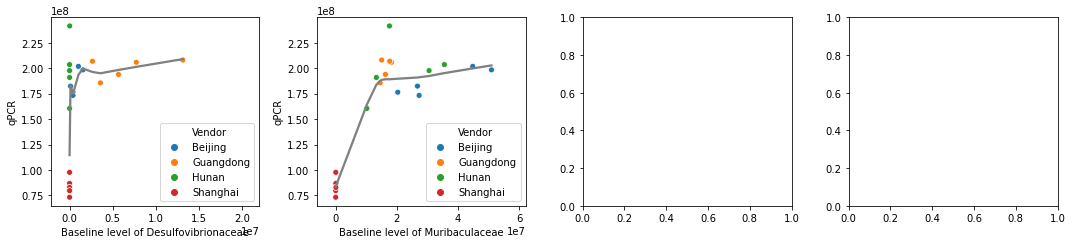

In [22]:
lines = []
for taxa in primary_degraders:
    baseline = []
    for mice in set(df.MiceID):
        df_tmp = df[df.MiceID==mice].sort_values(by='Day')
        vendor = list(set(df_tmp.Vendor))[0]
        x = list(df_tmp.Day)
        baseline = df_tmp.loc[df_tmp.Day==0,taxa].values[0]
        y = list(df_tmp['qPCR'])
        mean_qpcr = simps(y,x)/np.max(x)
        lines.append([taxa, mice, vendor, baseline, mean_qpcr])
df_bsl_qpcr = pd.DataFrame(lines, columns = ['Taxa','MiceID','Vendor','Baseline','qPCR'])
df_bsl_qpcr = df_bsl_qpcr.sort_values('Vendor')

lines = []
for k,taxa in enumerate(primary_degraders):
    coef, P = spearmanr(df_bsl_qpcr[df_bsl_qpcr.Taxa==taxa].Baseline, df_bsl_qpcr[df_bsl_qpcr.Taxa==taxa].qPCR)
    lines.append([taxa, coef, P])
    
df_res = pd.DataFrame(lines, columns=['SCFA','Coef','P'])
df_res['P_adj'] = multipletests(df_res.P, method='fdr_bh')[1]

fig, ax=plt.subplots(nrows=1, ncols=4, figsize=(15,3.5))
for k,taxa in enumerate(['Desulfovibrionaceae','Muribaculaceae']):
    _ = sns.regplot(x='Baseline', y='qPCR', data=df_bsl_qpcr[df_bsl_qpcr.Taxa==taxa], ax=ax[k], scatter=False, color='gray', ci=68, lowess=True)
    _ = sns.scatterplot(x='Baseline', y='qPCR', data=df_bsl_qpcr[df_bsl_qpcr.Taxa==taxa], ax=ax[k], hue='Vendor')
    _ = ax[k].set_xlabel('Baseline level of %s'%(taxa))
    if k==0:
        _ = ax[k].set_xlim([-2.2e6, 2.2e7])
    elif k==1:
        _ = ax[k].set_xlim([-6.2e6, 6.2e7])
    elif k==2:
        _ = ax[k].set_xlim([-1.2e5, 1.2e6])
    elif k==3:
        _ = ax[k].set_xlim([-1.2e6, 1.2e7])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_baseline_responder_and_load.svg", format="svg")

In [23]:
df_res

,SCFA,Coef,P,P_adj
0,Muribaculaceae,0.631579,0.002818,0.008455
1,Faecalibaculum,-0.070677,0.767158,0.767158
2,Desulfovibrionaceae,0.524097,0.017691,0.026536


# Correlation between baseline level of top four taxa and propionate

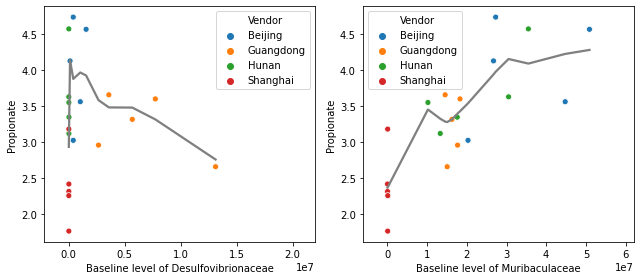

In [26]:
lines = []
for taxa in ['Desulfovibrionaceae','Muribaculaceae']:
    baseline = []
    for mice in set(df.MiceID):
        df_tmp = df[df.MiceID==mice].sort_values(by='Day')
        vendor = list(set(df_tmp.Vendor))[0]
        x = list(df_tmp.Day)
        baseline = df_tmp.loc[df_tmp.Day==0,taxa].values[0]
        y = list(df_tmp['Propionate'])
        mean_ppa = simps(y,x)/np.max(x)
        lines.append([taxa, mice, vendor, baseline, mean_ppa])
df_bsl_ppa = pd.DataFrame(lines, columns = ['Taxa','MiceID','Vendor','Baseline','Propionate'])
df_bsl_ppa = df_bsl_ppa.sort_values('Vendor')

lines = []
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(9,4))
for k,taxa in enumerate(['Desulfovibrionaceae','Muribaculaceae']):
    _ = sns.regplot(x='Baseline', y='Propionate', data=df_bsl_ppa[df_bsl_ppa.Taxa==taxa], ax=ax[k], scatter=False, color='gray', ci=68, lowess=True)
    _ = sns.scatterplot(x='Baseline', y='Propionate', data=df_bsl_ppa[df_bsl_ppa.Taxa==taxa], ax=ax[k], hue='Vendor')
    coef, P = spearmanr(df_bsl_ppa[df_bsl_ppa.Taxa==taxa].Baseline, df_bsl_ppa[df_bsl_ppa.Taxa==taxa].Propionate)
    lines.append([taxa, coef, P])
    _ = ax[k].set_xlabel('Baseline level of %s'%(taxa))
    if k==0:
        _ = ax[k].set_xlim([-2.2e6, 2.2e7])
    elif k==1:
        _ = ax[k].set_xlim([-6.2e6, 6.2e7])
    elif k==2:
        _ = ax[k].set_xlim([-1.2e5, 1.2e6])
    elif k==3:
        _ = ax[k].set_xlim([-1.2e6, 1.2e7])

df_res = pd.DataFrame(lines, columns=['SCFA','Coef','P'])
df_res['P_adj'] = multipletests(df_res.P, method='fdr_bh')[1]

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_baseline_sig_responder_and_propionate.svg", format="svg")

In [27]:
df_res

,SCFA,Coef,P,P_adj
0,Desulfovibrionaceae,0.183735,0.438093,0.438093
1,Muribaculaceae,0.750376,0.000138,0.000277
